# North Atlantic O2
    - 3D isopycnal version
    - This script shows a workflow of estimating O2 anomalies usign ESM output and a few ML regressors
    - O2 is estimated as a function of T, S, long, lat, year, month (below 100m, month is always March = 2)
    - year is measured since 1965-01
    - Estimation methods include Neural Network and Random Forest Regression
    - 80-20 divide between training and test data
    - K-fold cross validation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import sklearn as skl
import gsw

### First prepare O2, T, S, stratification data

In [2]:
# Define the model name as a string
model = 'IPSL-CM6A-LR'

# Define the directory where the CMIP6 data for the model is stored
dir = '/glade/campaign/univ/ugit0034/cmip6/' + model + '/'

# Define the directory where the dataset for the model is stored
dira = '/glade/work/acervania/dataset/model/' + model + '/'

# Open the dataset for oxygen concentration for the specified model and time range
ds0 = xr.open_dataset(dir + 'o2_' + model + '_196501-201412_subsampled_noisy.nc')

# Open the dataset for sea surface salinity for the specified model and time range
ds1 = xr.open_dataset(dir + 'so_' + model + '_196501-201412_subsampled.nc')

# Open the dataset for sea surface temperature for the specified model and time range
ds2 = xr.open_dataset(dir + 'thetao_' + model + '_196501-201412_subsampled.nc')


In [3]:
# Open the dataset for the basin mask
dsm = xr.open_dataset('/glade/campaign/univ/ugit0034/cmip6/basin_mask_01.nc')

# Open the dataset for observational data coverage for the specified time range
dsd = xr.open_dataset('/glade/campaign/univ/ugit0034/cmip6/mask_woagrid_196501-201412.nc')


In [4]:
# Get longitude values from the ds0 dataset and convert to a NumPy array
x = ds0.lon.to_numpy()

# Get latitude values from the ds0 dataset and convert to a NumPy array
y = ds0.lat.to_numpy()

# Create a 1D array of longitude values ranging from 0 to 359 with a step size of 1
xi = np.arange(0, 360, 1)

# Create a 1D array of latitude values ranging from 0 to 179 with a step size of 1
yi = np.arange(0, 180, 1)

# Create a 2D grid of longitude and latitude values using meshgrid
xx, yy = np.meshgrid(x, y)

# Create a 2D grid of longitude and latitude values using meshgrid for the new coordinates
xxi, yyi = np.meshgrid(xi, yi)


In [5]:
# Extract the basin mask from the dsm dataset
mask = dsm.basin_mask

# Extract and convert oxygen concentration to millimoles per cubic meter (mmol/m^3)
o2 = ds0.o2_mednoise * 1e3

# Extract sea surface salinity from the ds1 dataset
so = ds1.so

# Extract sea surface temperature from the ds2 dataset
to = ds2.thetao

# Extract the depth values for oxygen concentration from the o2 dataset and convert to NumPy array
zmod = o2.depth.to_numpy()

# Extract the depth values for the basin mask from the mask dataset and convert to NumPy array
zmask = mask.depth.to_numpy()


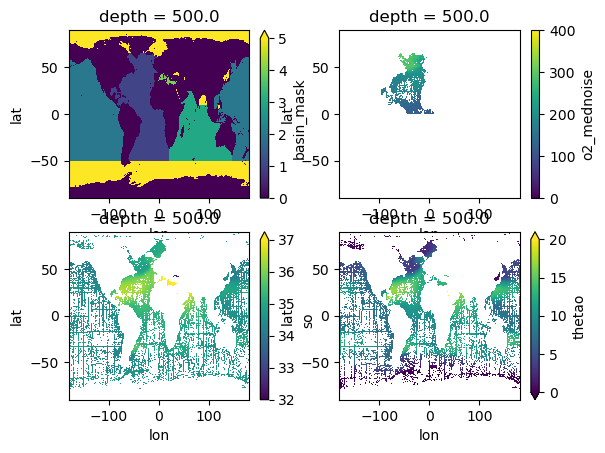

In [6]:
# Define the depth level to be plotted
zlev = 500

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2)

# Plot the basin mask at the specified depth level
mask.sel(depth=zlev).plot(ax=ax[0, 0], vmin=0, vmax=5, label='basin_mask')

# Plot the mean oxygen concentration over time at the specified depth level
o2.sel(depth=zlev).mean('time').plot(ax=ax[0, 1], vmin=0, vmax=400, label='O2')

# Plot the mean sea surface salinity over time at the specified depth level
so.sel(depth=zlev).mean('time').plot(ax=ax[1, 0], vmin=32, vmax=37, label='S')

# Plot the mean sea surface temperature over time at the specified depth level
to.sel(depth=zlev).mean('time').plot(ax=ax[1, 1], vmin=0, vmax=20, label='T')


In [7]:
# Create an empty array to store the basin mask data with the same shape as o2
ma = np.zeros(np.shape(o2[0,:,:,:]))

# Loop through each depth level and retrieve the corresponding basin mask from WOD
for k, dep in enumerate(zmod):
    # Select the basin mask at the nearest depth level and convert to NumPy array
    ma[k,:,:] = dsm.basin_mask.sel(depth=dep, method='nearest').to_numpy()


### Prepare the input data

In [8]:
# Convert oxygen concentration data to a NumPy array
doa = o2.to_numpy()

# Convert sea surface salinity data to a NumPy array
dsa = so.to_numpy()

# Convert sea surface temperature data to a NumPy array
dta = to.to_numpy()


In [9]:
# Prepare latitude and longitude data

# Create a 4D array with longitude values repeated along the time dimension
xx1 = np.tile(xx, [600, 19, 1, 1])

# Create a 4D array with latitude values repeated along the time dimension
yy1 = np.tile(yy, [600, 19, 1, 1])

# Create a 4D array representing time values from 0 to 599 repeated across other dimensions
tt0 = np.tile(np.arange(0, 600, 1), [19, 180, 360, 1])

# Transpose the time dimension to be the first dimension
tt1 = np.transpose(tt0, (3, 0, 1, 2))

# Calculate the month component for each time value
mn1 = tt1 % 12

# Calculate the year component for each time value
yr1 = (tt1 - mn1) / 12

# Set month values to 2 (March) for depths below 100m
kdeep = (zmod >= 100)
mn1[:, kdeep, :, :] = 2

In [10]:
# Apply mask for the North Atlantic

# Replace values in the oxygen concentration array where the mask is 1 (indicating North Atlantic) and latitude is positive, with NaN
doa = np.where((ma == 1) & (yy > 0), doa, np.nan)

# Replace values in the sea surface salinity array where the mask is 1 (indicating North Atlantic) and latitude is positive, with NaN
dsa = np.where((ma == 1) & (yy > 0), dsa, np.nan)

# Replace values in the sea surface temperature array where the mask is 1 (indicating North Atlantic) and latitude is positive, with NaN
dta = np.where((ma == 1) & (yy > 0), dta, np.nan)


/glade/scratch/ito/ipykernel_37850/3369883527.py:12: RuntimeWarning: Mean of empty slice
  ax[0,1].pcolormesh(np.nanmean(doa[:,klev,:,:],axis=0), vmin=0, vmax=400, label='O2')
/glade/scratch/ito/ipykernel_37850/3369883527.py:15: RuntimeWarning: Mean of empty slice
  ax[1,0].pcolormesh(np.nanmean(dsa[:,klev,:,:],axis=0), vmin=33, vmax=36, label='S')
/glade/scratch/ito/ipykernel_37850/3369883527.py:18: RuntimeWarning: Mean of empty slice
  ax[1,1].pcolormesh(np.nanmean(dta[:,klev,:,:],axis=0), vmin=0, vmax=20, label='T')


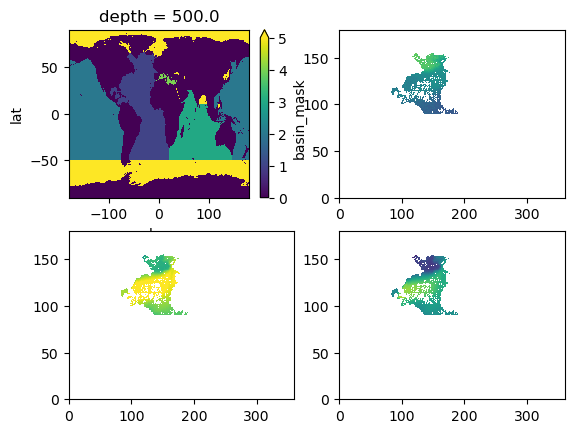

In [11]:
# Define the depth level to be plotted
zlev = 500
klev = int(np.sum((zmod<=zlev))-1)

# Create a 2x2 grid of subplots
fig, ax = plt.subplots(2, 2)

# Plot the basin mask at the specified depth level
mask.sel(depth=zlev).plot(ax=ax[0, 0], vmin=0, vmax=5, label='basin_mask')

# Plot the mean oxygen concentration over time at the specified depth level
ax[0,1].pcolormesh(np.nanmean(doa[:,klev,:,:],axis=0), vmin=0, vmax=400, label='O2')

# Plot the mean sea surface salinity over time at the specified depth level
ax[1,0].pcolormesh(np.nanmean(dsa[:,klev,:,:],axis=0), vmin=33, vmax=36, label='S')

# Plot the mean sea surface temperature over time at the specified depth level
ax[1,1].pcolormesh(np.nanmean(dta[:,klev,:,:],axis=0), vmin=0, vmax=20, label='T')


### Now we have the anormaly data for the North Atlantic. Remove NaNs and organize them into 1d array

In [12]:
# Create data vectors

# Flatten the oxygen concentration array to a 1D array
doa0 = doa.flatten()

# Flatten the sea surface salinity array to a 1D array
dsa0 = dsa.flatten()

# Flatten the sea surface temperature array to a 1D array
dta0 = dta.flatten()

# Sum the corresponding elements of the flattened arrays to create the combined data vector
dd = doa0 + dsa0 + dta0


In [13]:
# Filter out NaN values from the data vectors

# Filter out NaN values from the flattened oxygen concentration array and create a new array
doa1 = doa0[np.isnan(dd) == False]

# Filter out NaN values from the flattened sea surface salinity array and create a new array
dsa1 = dsa0[np.isnan(dd) == False]

# Filter out NaN values from the flattened sea surface temperature array and create a new array
dta1 = dta0[np.isnan(dd) == False]


In [14]:
# Flatten the arrays

# Flatten the 4D array 'xx1' to a 1D array
xx0 = xx1.flatten()

# Flatten the 4D array 'yy1' to a 1D array
yy0 = yy1.flatten()

# Flatten the 4D array 'mn1' (month component) to a 1D array
mn0 = mn1.flatten()

# Flatten the 4D array 'yr1' (year component) to a 1D array
yr0 = yr1.flatten()


In [15]:
# Remove NaN values

# Filter out NaN values from the flattened longitude array and create a new array
xx1 = xx0[np.isnan(dd) == False]

# Filter out NaN values from the flattened latitude array and create a new array
yy1 = yy0[np.isnan(dd) == False]

# Filter out NaN values from the flattened year component array and create a new array
yr1 = yr0[np.isnan(dd) == False]

# Filter out NaN values from the flattened month component array and create a new array
mn1 = mn0[np.isnan(dd) == False]

# Calculate the number of samples in the filtered data
Nsample = np.size(doa1)

# Print the number of samples
print(Nsample)


549743


In [35]:
# Generate data matrix and standardize it

# Create a 2D array 'X' containing dsa1, dta1, xx1, yy1, yr1, mn1 as its rows
X = np.array([dsa1, dta1, xx1, yy1, yr1, mn1])

# Set 'y' as the target variable containing doa1
y = doa1

# Calculate mean and standard deviation along each row of 'X' to standardize the data
Xm = np.mean(X, axis=1)  # Mean values
Xstd = np.std(X, axis=1)  # Standard deviation values

# Get the total number of samples (size of 'y')
N = np.size(y)

# Normalize 'X' and 'y'
Xa = (X.T - Xm) / Xstd  # Standardize 'X'
ym = np.mean(y)  # Mean value of 'y'
ystd = np.std(y)  # Standard deviation of 'y'
ya = (y - ym) / ystd  # Standardize 'y'

# Save the mean and standard deviation values for later use in a npz file
np.savez(f'ML_params_{model}.npz', Xm=Xm, Xstd=Xstd, ym=ym, ystd=ystd)


## ML

### First split the data into training and test set

In [17]:
# Import the necessary function for splitting the data
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets

# Xa: The standardized feature matrix
# ya: The standardized target variable

# Set random_state to ensure reproducibility
# test_size is set to 20%, meaning 80% of the data will be used for training and 20% for testing
X_train, X_test, y_train, y_test = train_test_split(Xa, ya, random_state=1, test_size=0.2)


In [18]:
# Calculate the sizes of the training and testing sets

# 'a' is the size of the training set (number of samples in y_train)
a = y_train.size

# 'b' is the size of the testing set (number of samples in y_test)
b = y_test.size

# Calculate and print the fraction of the data used for training
train_fraction = a / (a + b)
print(f'The fraction of train data is {train_fraction}')


The fraction of train data is 0.7999992723872792


### Random Forest estimator (RFregr)

In [19]:
# Import necessary libraries for Random Forest Regressor and Grid Search Cross Validation

# Import the RandomForestRegressor class from the ensemble module of scikit-learn
from sklearn.ensemble import RandomForestRegressor

# Import the GridSearchCV class from the model_selection module of scikit-learn
from sklearn.model_selection import GridSearchCV


In [20]:
# Initialize a Random Forest Regressor

# Create an instance of the RandomForestRegressor class
clf = RandomForestRegressor()

# Define hyperparameters for tuning

# 'n_estimators': Number of trees in the forest
# 'max_features': Maximum number of features considered for splitting a node
parameters = {'n_estimators':[100], 'max_features':[1]}

# Initialize a GridSearchCV object

# Create an instance of GridSearchCV for hyperparameter tuning
RFregr = GridSearchCV(clf, parameters)

# Fit the model

# Train the Random Forest Regressor using the training data
RFregr.fit(X_train, y_train)


GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'max_features': [1], 'n_estimators': [100]})

In [21]:
# Access cross-validation results

# RFregr.cv_results_ contains the results of the cross-validation process,
# including scores, parameter values, and computation times.

RFregr.cv_results_

{'mean_fit_time': array([43.1307735]),
 'std_fit_time': array([0.58812956]),
 'mean_score_time': array([4.76671762]),
 'std_score_time': array([0.26511221]),
 'param_max_features': masked_array(data=[1],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[100],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'max_features': 1, 'n_estimators': 100}],
 'split0_test_score': array([0.93675727]),
 'split1_test_score': array([0.937858]),
 'split2_test_score': array([0.93571553]),
 'split3_test_score': array([0.93735131]),
 'split4_test_score': array([0.93726811]),
 'mean_test_score': array([0.93699004]),
 'std_test_score': array([0.0007266]),
 'rank_test_score': array([1], dtype=int32)}

In [22]:
# Use the best-fit parameters and make predictions using X_test data

# 'RFregr.predict(X_test)' applies the trained Random Forest Regressor model with the best-fit parameters
# to make predictions on the test data.
out = RFregr.predict(X_test)


R2 score =  0.9379129063380621
RMSE =  13.354028371639226


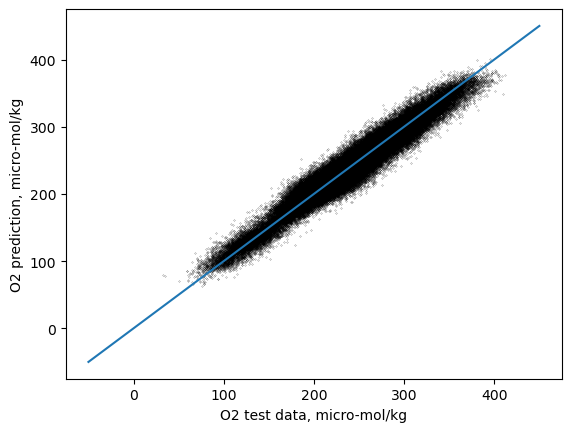

In [23]:
# Transform standardized predictions and test data back to original units

# 'out' contains predictions in standardized units, this line transforms them back to original units
o2est = out * ystd + ym

# 'y_test' contains test data in standardized units, this line transforms them back to original units
o2test = y_test * ystd + ym

# Plot the predicted vs. actual values

# Scatter plot of predicted vs. actual oxygen concentrations
plt.plot(o2test, o2est, 'k.', markersize=.3)

# Plot a diagonal line representing perfect predictions
plt.plot([-50, 450], [-50, 450])

# Add labels and title to the plot
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')

# Calculate and print R2 score

# Calculate the correlation coefficient between the predicted and actual values
temp = np.corrcoef(o2est, o2test)

# Calculate R2 score
R2val_RF = temp[0, 1] ** 2
print('R2 score = ', R2val_RF)

# Calculate and print RMSE

# Calculate the Root Mean Squared Error (RMSE) between the predicted and actual values
RMSE_RF = np.sqrt(np.mean((o2est - o2test) ** 2))
print('RMSE = ', RMSE_RF)


### shallow Neural Network estimator (SNNregr)

In [24]:
# Import the necessary library for Neural Network Regressor

# Import the MLPRegressor class from the neural_network module of scikit-learn
from sklearn.neural_network import MLPRegressor


In [25]:
# Initialize a Shallow Neural Network (NN) Regressor

# Create an instance of the MLPRegressor class with a maximum of 1000 iterations
clf = MLPRegressor(max_iter=1000)

# Define hyperparameters for tuning

# 'hidden_layer_sizes': Number of neurons in each hidden layer
# 'alpha': L2 penalty (regularization term) parameter
parameters = {'hidden_layer_sizes': [[10, 10]], 'alpha': [.01]}

# Initialize a GridSearchCV object for hyperparameter tuning

# Create an instance of GridSearchCV for hyperparameter tuning with the defined parameters
sNNregr = GridSearchCV(clf, parameters)


In [26]:
# Train the Shallow Neural Network (NN) Regressor using the test data

# This line fits the Shallow Neural Network Regressor model using the test data (X_test, y_test).
sNNregr.fit(X_test, y_test)


GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.01], 'hidden_layer_sizes': [[10, 10]]})

In [27]:
# Use the trained Shallow Neural Network (NN) Regressor model to make predictions

# 'sNNregr.predict(X_test)' applies the trained Shallow Neural Network Regressor model
# to make predictions on the test data.
out = sNNregr.predict(X_test)

# Access cross-validation results

# 'sNNregr.cv_results_' contains the results of the cross-validation process,
# including scores, parameter values, and computation times.
sNNregr.cv_results_

{'mean_fit_time': array([7.47358375]),
 'std_fit_time': array([1.45939798]),
 'mean_score_time': array([0.00370584]),
 'std_score_time': array([0.00189844]),
 'param_alpha': masked_array(data=[0.01],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([10, 10])],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01, 'hidden_layer_sizes': [10, 10]}],
 'split0_test_score': array([0.9153002]),
 'split1_test_score': array([0.91105958]),
 'split2_test_score': array([0.9128918]),
 'split3_test_score': array([0.91907055]),
 'split4_test_score': array([0.90783419]),
 'mean_test_score': array([0.91323126]),
 'std_test_score': array([0.00380362]),
 'rank_test_score': array([1], dtype=int32)}

R2 =  0.9186139309514832
RMSE =  15.288581826509674


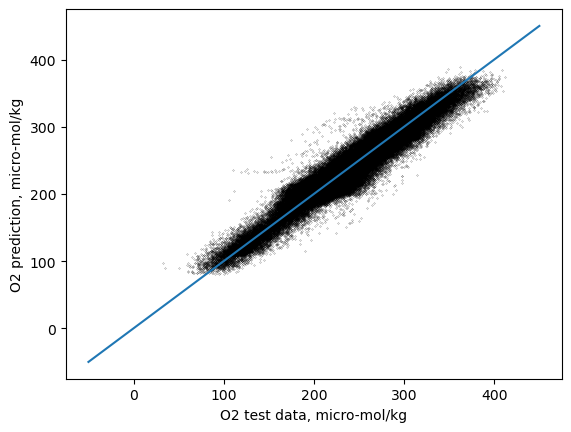

In [28]:
# Transform standardized predictions and test data back to original units

# 'out' contains predictions in standardized units, this line transforms them back to original units
o2est = out * ystd + ym

# 'y_test' contains test data in standardized units, this line transforms them back to original units
o2test = y_test * ystd + ym

# Plot the predicted vs. actual values

# Scatter plot of predicted vs. actual oxygen concentrations
plt.plot(o2test, o2est, 'k.', markersize=.3)

# Plot a diagonal line representing perfect predictions
plt.plot([-50, 450], [-50, 450])

# Add labels and title to the plot
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')

# Calculate and print R2 score

# Calculate the correlation coefficient between the predicted and actual values
temp = np.corrcoef(o2est, o2test)
R2val_sNN = temp[0, 1]**2
print('R2 = ', R2val_sNN)

# Calculate and print RMSE

# Calculate the Root Mean Squared Error (RMSE) between the predicted and actual values
RMSE_sNN = np.sqrt(np.mean((o2est - o2test) ** 2))
print('RMSE = ', RMSE_sNN)


### deep Neural Network estimator (NNregr)

In [29]:
# Initialize and train a Deep Neural Network (NN) Regressor

# Create an instance of the MLPRegressor class with a maximum of 1000 iterations
# and train it using the training data (X_train, y_train).
dNNregr = MLPRegressor(max_iter=1000).fit(X_train, y_train)


In [30]:
# Initialize a Deep Neural Network (NN) Regressor

# Create an instance of the MLPRegressor class with a maximum of 1000 iterations
clf = MLPRegressor(max_iter=1000)

# Define hyperparameters for tuning

# 'hidden_layer_sizes': Number of neurons in each hidden layer
# 'alpha': L2 penalty (regularization term) parameter
parameters = {'hidden_layer_sizes': [[10, 10, 10, 10]], 'alpha': [.01]}

# Initialize a GridSearchCV object for hyperparameter tuning

# Create an instance of GridSearchCV for hyperparameter tuning with the defined parameters
dNNregr = GridSearchCV(clf, parameters)


In [31]:
# Train the Deep Neural Network (NN) Regressor using the test data

# This line fits the Deep Neural Network Regressor model using the test data (X_test, y_test).
dNNregr.fit(X_test, y_test)


GridSearchCV(estimator=MLPRegressor(max_iter=1000),
             param_grid={'alpha': [0.01],
                         'hidden_layer_sizes': [[10, 10, 10, 10]]})

In [32]:
# Use the trained Deep Neural Network (NN) Regressor model to make predictions

# 'dNNregr.predict(X_test)' applies the trained Deep Neural Network Regressor model
# to make predictions on the test data.
out = dNNregr.predict(X_test)

# Access cross-validation results

# 'dNNregr.cv_results_' contains the results of the cross-validation process,
# including scores, parameter values, and computation times.
dNNregr.cv_results_

{'mean_fit_time': array([16.0219698]),
 'std_fit_time': array([3.1873689]),
 'mean_score_time': array([0.01271181]),
 'std_score_time': array([0.00380725]),
 'param_alpha': masked_array(data=[0.01],
              mask=[False],
        fill_value='?',
             dtype=object),
 'param_hidden_layer_sizes': masked_array(data=[list([10, 10, 10, 10])],
              mask=[False],
        fill_value='?',
             dtype=object),
 'params': [{'alpha': 0.01, 'hidden_layer_sizes': [10, 10, 10, 10]}],
 'split0_test_score': array([0.92651165]),
 'split1_test_score': array([0.92515065]),
 'split2_test_score': array([0.92275725]),
 'split3_test_score': array([0.92433788]),
 'split4_test_score': array([0.92620182]),
 'mean_test_score': array([0.92499185]),
 'std_test_score': array([0.00135795]),
 'rank_test_score': array([1], dtype=int32)}

R2 =  0.9249169251354289
RMSE =  14.70075875903632


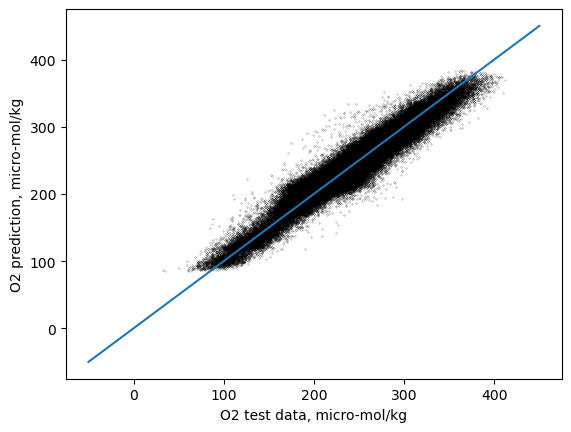

In [33]:
# Transform standardized predictions and test data back to original units

# 'out' contains predictions in standardized units, this line transforms them back to original units
o2est = out * ystd + ym

# 'y_test' contains test data in standardized units, this line transforms them back to original units
o2test = y_test * ystd + ym

# Plot the predicted vs. actual values

# Scatter plot of predicted vs. actual oxygen concentrations
plt.plot(o2test, o2est, 'k.', markersize=.3)

# Plot a diagonal line representing perfect predictions
plt.plot([-50, 450], [-50, 450])

# Add labels and title to the plot
plt.ylabel('O2 prediction, micro-mol/kg')
plt.xlabel('O2 test data, micro-mol/kg')

# Calculate and print R2 score

# Calculate the correlation coefficient between the predicted and actual values
temp = np.corrcoef(o2est, o2test)

# Calculate R2 score
R2val_NN = temp[0, 1] ** 2
print('R2 = ', R2val_NN)

# Calculate and print RMSE

# Calculate the Root Mean Squared Error (RMSE) between the predicted and actual values
RMSE_NN = np.sqrt(np.mean((o2est - o2test) ** 2))
print('RMSE = ', RMSE_NN)


In [36]:
# Save the trained models to files

# Import the joblib module for model serialization
import joblib

# Save the Random Forest Regressor model to a file named 'RF_model.sav'
filename = f'RF_model_{model}.sav'
joblib.dump(RFregr, filename)

# Save the Shallow Neural Network Regressor model to a file named 'sNN_model.sav'
filename = f'sNN_model_{model}.sav'
joblib.dump(sNNregr, filename)

# Save the Deep Neural Network Regressor model to a file named 'dNN_model.sav'
filename = f'dNN_model_{model}.sav'
joblib.dump(dNNregr, filename)


['dNN_model_IPSL-CM6A-LR.sav']